# Linear Kernel Parameterization <a name="head"></a>

This is a tutorial to give an indication of how the linear kernels works. A Gaussian process will be trained on a toy function and parameters explicitly varied to give a clear indication of their impact on the predicted function. The data is generated randomly, it may be beneficial to run through the notebook a number of times to see how the data generation impacts the predicted function.

The linear kernel is defined as follows:

$$
k(x,x')=\sigma^2_b + \sigma^2_v \left( x-c \right) \left( x'−c \right)
$$

Where $x$ and $x'$ are feature vectors, $\sigma_b$ defines a scaling factor on the descriptor and $\sigma_v$ the scaling on the variance and $c$ a constant.

## Table of Contents
[(Back to top)](#head)

-   [Data Setup](#data-setup)
-   [Constant parameter](#constant-parameter)
-   [Descriptor scaling parameter](#descriptor-scaling-parameter)
-   [Variance scaling parameter](#variance-scaling-parameter)
-   [Hyperparameter optimization](#hyperparameter-optimization)
-   [Conclusions](#conclusions)

## Data Setup <a name="data-setup"></a>
[(Back to top)](#head)

First, we define the necessary imports for the tutorial.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from atoml.regression import GaussianProcess
from atoml.regression.cost_function import get_error

We can set up a 2D-function to model with the following function.

In [2]:
def afunc(x):
    """Define some polynomial function."""
    y = x - 50.
    p = (y + 4) * (y + 4) * (y + 1) * (y - 1) * (y - 3.5) * (y - 2) * (y - 1)
    p += 40. * y + 80. * np.sin(10. * x)
    return 1. / 20. * p + 500

We can also define a plotting function at this stage.

In [3]:
def plot(sub, prediction):
    """Plotting function."""
    ax = fig.add_subplot(sub)
    ax.plot(linex, liney, '-', lw=1, color='black')
    ax.plot(train, target, 'o', alpha=0.5, color='black')
    ax.plot(test, prediction, 'r-', lw=1, alpha=0.8)
    plt.xlabel('Descriptor')
    plt.ylabel('Response')
    plt.axis('tight')

And then generate some training and testing data. Training the Gaussian process is performed with 17 data points, and a small amount of noise added. A far greater number of test data points are defined (513) in total. This provides a smooth predicted function so we can more clearly see what is happening with the predictions with a decent amount of detail.

In [4]:
# A number of training points in x.
train_points = 17
noise_magnitude = 1.

# Randomly generate the training datapoints x.
train = 7.6 * np.random.sample((train_points, 1)) - 4.2 + 50
# Each element in the list train can be referred to as a fingerprint.
# Call the underlying function to produce the target values.
target = np.array(afunc(train))

# Add random noise from a normal distribution to the target values.
target += noise_magnitude * np.random.randn(train_points, 1)

# Generate test datapoints x.
test_points = 513
test = np.vstack(np.linspace(np.min(train)-0.1, np.max(train)+0.1,
                             test_points))

# Store the known underlying function for plotting.
linex = np.linspace(np.min(test), np.max(test), test_points)
liney = afunc(linex)

## Scaling parameter <a name="constant-parameter"></a>
[(Back to top)](#head)

The scaling parameter $\sigma_v$ is varied in the following. We choose a range of values in the range of `[1., 1e-2, 1e-4, 1e-6]`, iterate over them and plot the predictions from the resulting model. It is seen that as the scaling parameter is decreased, the slope on the predictions also decreases. For the smallest scaling parameter of `1e-6`, there is essentially zero slope and the Gaussian process simply predicts the mean of the data.

Gaussian regression error with 1.0 width: 14.919
Gaussian regression error with 0.01 width: 14.912
Gaussian regression error with 0.0001 width: 15.283
Gaussian regression error with 1e-06 width: 18.582


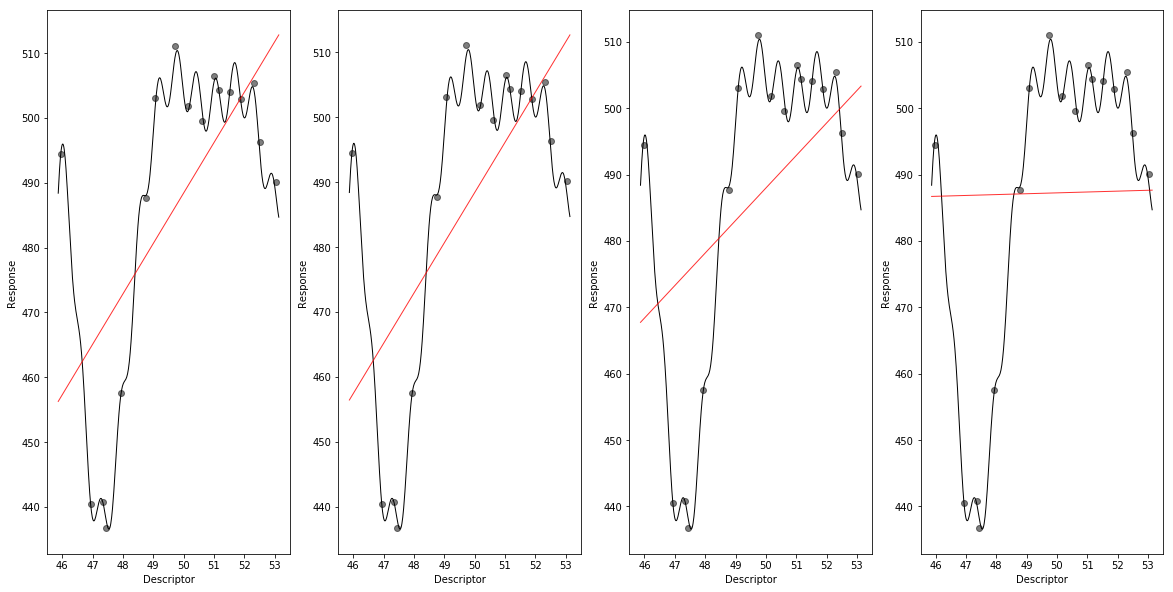

In [5]:
fig = plt.figure(figsize=(20, 10))

for w, p in zip([1., 1e-2, 1e-4, 1e-6], [141, 142, 143, 144]):
    kdict = {'k1': {'type': 'linear', 'scaling': w}}
    # Set up the prediction routine.
    gp = GaussianProcess(kernel_dict=kdict, regularization=1e-3,
                         train_fp=train,
                         train_target=target,
                         optimize_hyperparameters=False, scale_data=True)
    # Do predictions.
    fit = gp.predict(test_fp=test, uncertainty=True)

    # Get average errors.
    error = get_error(fit['prediction'], afunc(test))
    print('Gaussian regression error with {0} width: {1:.3f}'.format(
        w, error['absolute_average']))

    # Plotting.
    plot(p, fit['prediction'])

## Regularization parameter <a name="constant-parameter"></a>
[(Back to top)](#head)

The regularization parameter is varied within the range of `[1., 1e-1, 1e-2, 1e-3]`. Here we find that for larger values the model will under-fit. This will essentially result in the mean of the data being returned across the range of test values. When the regularization parameter gets small enough, it will have little impact on the model predictions as it will be smaller than the noise on the data.

In [ ]:
fig = plt.figure(figsize=(20, 10))

for r, p in zip([1., 1e-1, 1e-2, 1e-3], [141, 142, 143, 144]):
    kdict = {'k1': {'type': 'linear', 'scaling': 1e-2}}
    # Set up the prediction routine.
    gp = GaussianProcess(kernel_dict=kdict, regularization=r,
                         train_fp=train,
                         train_target=target,
                         optimize_hyperparameters=False, scale_data=True)
    # Do predictions.
    fit = gp.predict(test_fp=test)

    # Get average errors.
    error = get_error(fit['prediction'], afunc(test))
    print('Gaussian regression error with {0} width: {1:.3f}'.format(
        w, error['absolute_average']))

    # Plotting.
    plot(p, fit['prediction'])

## Constant parameter <a name="constant-parameter"></a>
[(Back to top)](#head)

The constant parameter $\sigma_b$ is added as a second kernel. We test values in the range of `[1e-6, 0., 1e2, 1e6]`, however, this parameter has no impact on the predictions for this data.

In [ ]:
fig = plt.figure(figsize=(20, 10))

for c, p in zip([1e-6, 0., 1e2, 1e6], [141, 142, 143, 144]):
    kdict = {'k1': {'type': 'linear', 'scaling': 1e-2},
             'k2': {'type': 'constant', 'const': c}
            }
    # Set up the prediction routine.
    gp = GaussianProcess(kernel_dict=kdict, regularization=1e-3,
                         train_fp=train,
                         train_target=target,
                         optimize_hyperparameters=False, scale_data=True)
    # Do predictions.
    fit = gp.predict(test_fp=test)

    # Get average errors.
    error = get_error(fit['prediction'], afunc(test))
    print('Gaussian regression error with {0} width: {1:.3f}'.format(
        w, error['absolute_average']))

    # Plotting.
    plot(p, fit['prediction'])

## Hyperparameter optimization <a name="conclusions"></a>
[(Back to top)](#head)

This is really just to give a sense of the impact of changing the parameters on the prediction. In reality, we will use some automated hyperparameter optimization. This optimization is performed in the following resulting in what should be an optimal Gaussian process for the data available. In this case, the log-marginal likelihood is used to find a balance between over and under-fitting. Thus, the Gaussian process trained with the optimized hyperparameters may not give the smallest error.

In [ ]:
fig = plt.figure(figsize=(20, 10))

kdict = {'k1': {'type': 'linear', 'scaling': 1e-2},
         'k2': {'type': 'constant', 'const': 1.}
        }
# Set up the prediction routine.
gp = GaussianProcess(kernel_dict=kdict, regularization=1e-3,
                     train_fp=train,
                     train_target=target,
                     optimize_hyperparameters=True, scale_data=True)
# Do predictions.
fit = gp.predict(test_fp=test)

# Get average errors.
error = get_error(fit['prediction'], afunc(test))
print('Gaussian regression error: {0:.3f}'.format(
    error['absolute_average']))

# Plotting.
plot(p, fit['prediction'])

print('Optimized scale: {0:.3f}'.format(gp.kernel_dict['k1']['scaling']))
print('Optimized constant: {0:.3f}'.format(gp.kernel_dict['k2']['const']))
print('Optimized regularization: {0:.3f}'.format(gp.regularization))

## Conclusions <a name="conclusions"></a>
[(Back to top)](#head)

In this case, the scaling and regularization parameters are particularly important. The addition of the constant kernel has no affect on the accuracy of the model.